# Patient Heart Failure Analysis

# Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [53]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
  
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
  
  return (X_res, y_res)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', SVC())
    ])
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()
    
    return grid_search

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000))
    ])
    param_grid = {
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()

def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })
    return pd.DataFrame(model_performance).sort_values(by="Test Accuracy", ascending=False)

def pca_analysis(X):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  
  features = X.shape[1]
  results = []
  for n_components in range(1, features + 1):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        
        results.append({
            'Number of Components': n_components,
            'Cumulative Explained Variance': explained_variance
        })
  results_df = pd.DataFrame(results)
  return results_df

def test_k_best_columns(names, models, X, y, metric, metric_name, variance_window):
    
    model_performance = []
    total_score, runs = 0, 0
    for k in variance_window:
        fs = SelectKBest(score_func=metric, k=k)
        for i in range(len(models)):
            model = models[i]
            pipeline = Pipeline(steps=
                                [('scaler', StandardScaler()), 
                                ("power_tranformer",PowerTransformer()), 
                                (metric_name, fs),
                                ('model', model)])
            scores = evaluate_model(X, y, pipeline)
            mean_score = np.mean(scores)
            total_score += mean_score
            runs+=1
            model_performance.append({
                "Model": names[i],
                "Col #": k,
                "Metric": metric_name,
                "Mean": mean_score,
                "STD":np.std(scores)
            })
    performance_df = pd.DataFrame(model_performance)
    print(f"Average total Score: {total_score/runs}")
    return performance_df.sort_values(by="Mean", ascending=False)

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/heart_failure_clinical_records_dataset.csv", nrows=20000)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# Check For Nulls and Dupes

In [5]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

Class=1, Count=96, Percentage=32.107%
Class=0, Count=203, Percentage=67.893%


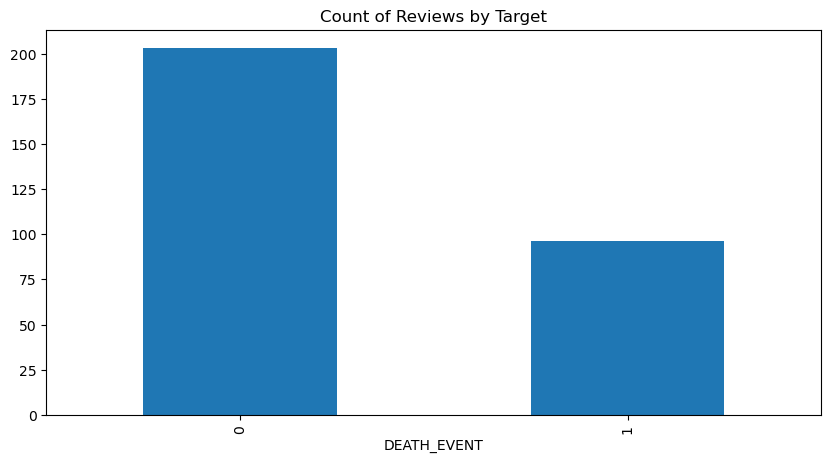

In [6]:

check_class_imbalance(df,df['DEATH_EVENT'], 'DEATH_EVENT')

# Unbalanced Dataset, will need to test multiple sampling methods

In [7]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [8]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


# Visuals

<AxesSubplot:>

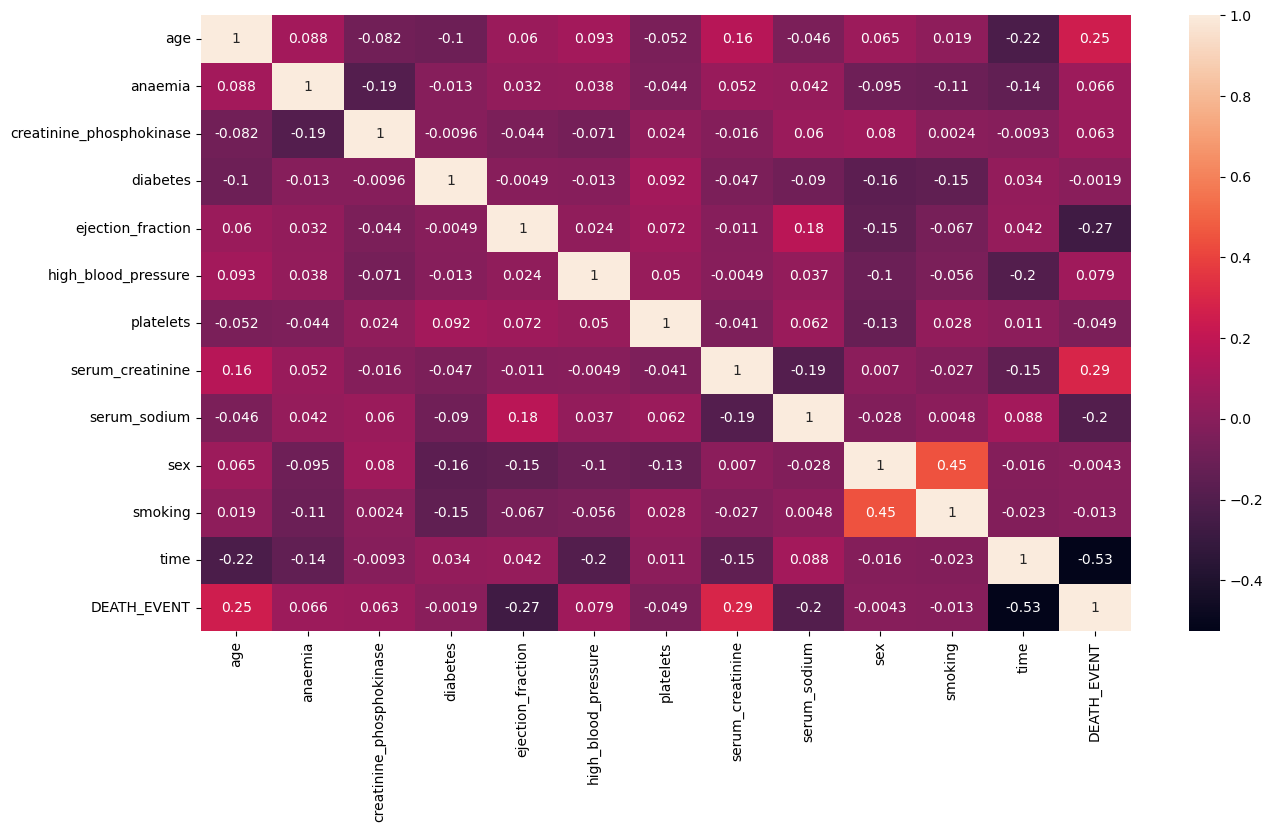

In [9]:
plt.figure(figsize=(15, 8))
sns.heatmap(data=df.corr(), annot=True)

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='time'>

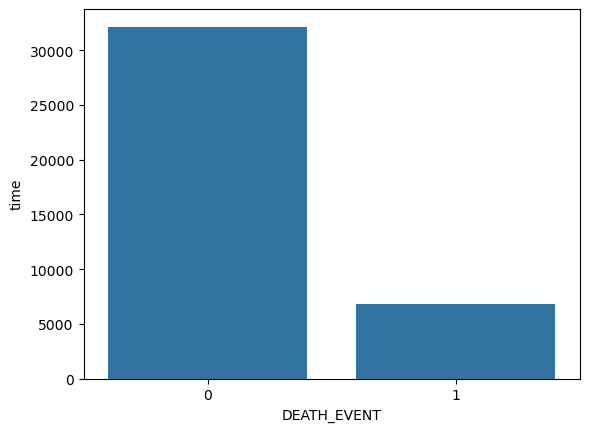

In [10]:
grouped_by_time = df.groupby("DEATH_EVENT")["time"].sum().reset_index()

sns.barplot(data=grouped_by_time, x="DEATH_EVENT", y="time")

# Death Event as a target variable could possibly be switched out with time as a feature variable, given there is a realtionship between amount of time between the next follow up after having heart failure. Less time between the next follow up indeicates death as a cause, indicates a higher probability of death.

<AxesSubplot:xlabel='DEATH_EVENT', ylabel='serum_creatinine'>

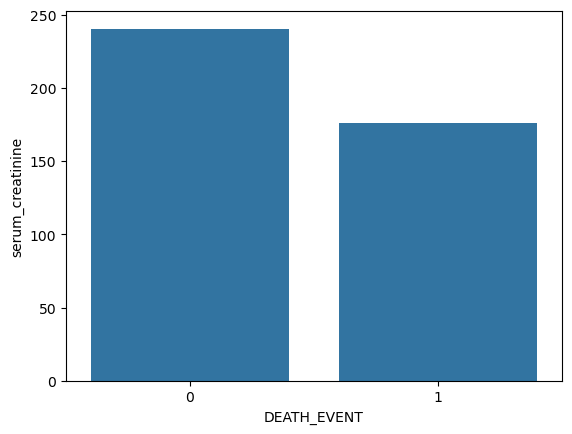

In [12]:
grouped_by_serum= df.groupby("DEATH_EVENT")["serum_creatinine"].sum().reset_index()

sns.barplot(data=grouped_by_serum, x="DEATH_EVENT", y="serum_creatinine")

# Separate Features

In [13]:
X,y = df.drop("DEATH_EVENT", axis=1), df['DEATH_EVENT']

# Advanced Model Metrics

In [17]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
0,LDA,0.733320,0.062503
1,LR,0.727034,0.059508
3,GNB,0.702886,0.078774
2,SVC,0.662689,0.078328
4,GPC,0.476842,0.114331


In [18]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
2,XGB,0.739677,0.053602
0,RFC,0.735213,0.081598
3,GBC,0.725306,0.062454
1,DTC,0.614915,0.063617


# Poor model Performance signals we need to use oversampling methods

# SMOTE First

In [19]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE")

In [20]:

names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
2,SVC,0.875197,0.027653
0,LDA,0.856844,0.028192
1,LR,0.853930,0.030931
3,GNB,0.848133,0.029924
4,GPC,0.841649,0.034697


In [21]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.884318,0.040022
2,XGB,0.882903,0.028744
3,GBC,0.867046,0.042052
1,DTC,0.795130,0.045139


# We have made a 15 point jump using SMOTE but lets test out more methods

# ADASYN

In [22]:
X_adasyn, y_adasyn = get_over_sampling_methods(X, y, "ADASYN")

In [23]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
2,SVC,0.876035,0.042739
3,GNB,0.864671,0.030822
0,LDA,0.862199,0.044238
1,LR,0.860336,0.043388
4,GPC,0.840529,0.043776


In [24]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
0,RFC,0.883809,0.032238
2,XGB,0.872962,0.033892
3,GBC,0.868579,0.034574
1,DTC,0.814803,0.040040


# Borderline SMOTE

In [25]:
X_bl, y_bl = get_over_sampling_methods(X, y, "BL-SMOTE")

In [26]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
2,SVC,0.862659,0.028333
3,GNB,0.853028,0.027199
4,GPC,0.839381,0.032300
0,LDA,0.838081,0.027060
1,LR,0.835083,0.029309


In [27]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
0,RFC,0.896919,0.026642
2,XGB,0.888127,0.025922
3,GBC,0.872869,0.029214
1,DTC,0.816267,0.034984


# BL Smote is in the lead for highest scores but lets try KNN-SMOTE

In [28]:
X_knn, y_knn = get_over_sampling_methods(X, y, "KNN-SMOTE")

In [29]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
2,SVC,0.866139,0.030766
4,GPC,0.853881,0.036886
3,GNB,0.843412,0.037240
0,LDA,0.838929,0.041598
1,LR,0.834637,0.042545


In [30]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
0,RFC,0.890957,0.026639
2,XGB,0.888559,0.025351
3,GBC,0.882594,0.028607
1,DTC,0.798336,0.040922


In [31]:
def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0 or idx ==3:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_without_reg(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X_bl, y_bl, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2,
  create_model_without_reg
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2", 'Without_Reg']
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_70592/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-05-06 15:19:33.861888: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_70592/1861942918.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05

,Model,Accuracy,Optimizer,Value
8,L2,0.590164,Adam,0.1000
0,Dropout,0.540984,Adam,0.1000
1,Dropout,0.540984,RmsProp,0.0100
2,Dropout,0.540984,SGD:0.01,0.0010
3,Dropout,0.540984,SGD:0.001,0.0001
4,L1,0.540984,Adam,0.1000
6,L1,0.540984,SGD:0.01,0.0010
7,L1,0.540984,SGD:0.001,0.0001
9,L2,0.540984,RmsProp,0.0100
10,L2,0.540984,SGD:0.01,0.0010


# SVM Tune

Best parameters: {'model__C': 0.8, 'model__kernel': 'rbf'}
Best cross-validation score: 0.856
Test accuracy: 0.861
              precision    recall  f1-score   support

           0       0.86      0.81      0.83        53
           1       0.86      0.90      0.88        69

    accuracy                           0.86       122
   macro avg       0.86      0.85      0.86       122
weighted avg       0.86      0.86      0.86       122



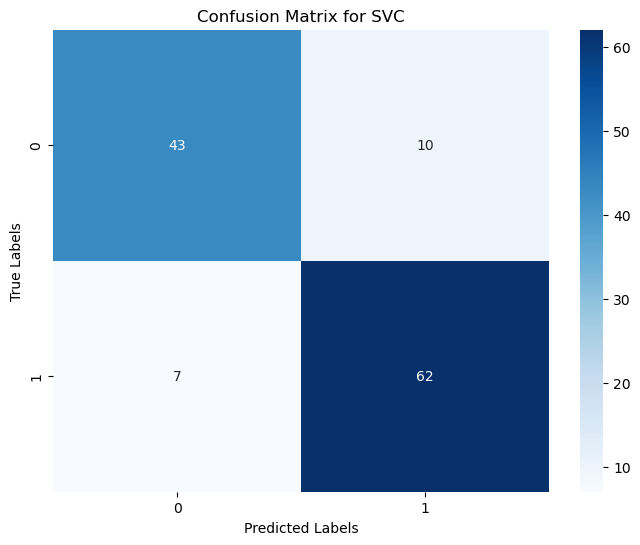

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [37]:
svm_tune_grid_search(X_bl, y_bl)

# LR Tune

Best parameters: {'model__C': 0.1, 'model__solver': 'newton-cg'}
Best cross-validation score: 0.822
Test accuracy: 0.836
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        53
           1       0.85      0.87      0.86        69

    accuracy                           0.84       122
   macro avg       0.83      0.83      0.83       122
weighted avg       0.84      0.84      0.84       122



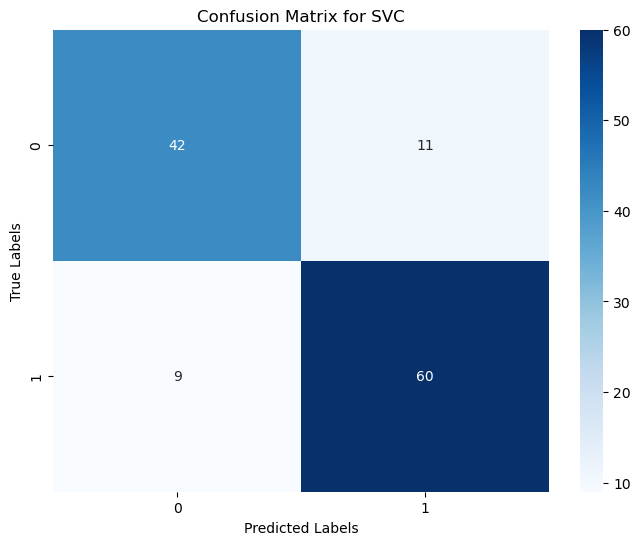

In [38]:
logistic_regression_tune_cv(X_bl, y_bl)

# Hyper Parameters Tree Models Tune

Best score for DTC: 0.839
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__splitter': 'random'}
Validation Test accuracy for DTC: 0.787
Test accuracy for DTC: 0.820
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.88      0.84        33
           1       0.84      0.75      0.79        28

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.82        61
weighted avg       0.82      0.82      0.82        61



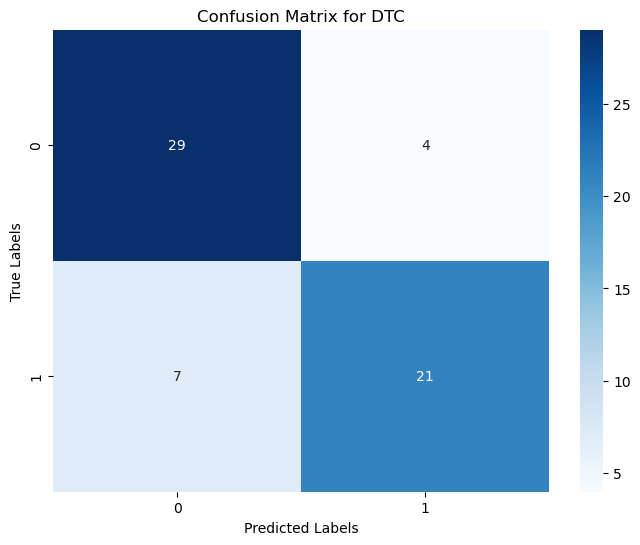

Best score for RFC: 0.887
Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Validation Test accuracy for RFC: 0.820
Test accuracy for RFC: 0.869
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        33
           1       0.92      0.79      0.85        28

    accuracy                           0.87        61
   macro avg       0.88      0.86      0.87        61
weighted avg       0.87      0.87      0.87        61



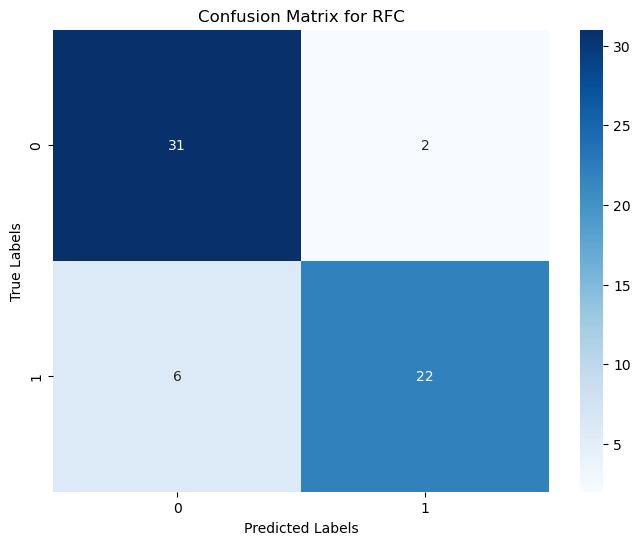

Best score for GBC: 0.879
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 300}
Validation Test accuracy for GBC: 0.787
Test accuracy for GBC: 0.885
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.89      0.86      0.87        28

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



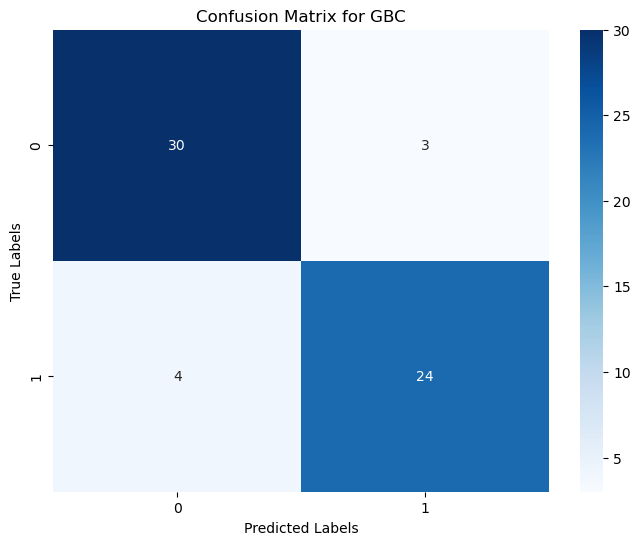

Best score for XGB: 0.865
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 7, 'model__n_estimators': 100}
Validation Test accuracy for XGB: 0.836
Test accuracy for XGB: 0.836
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        33
           1       0.88      0.75      0.81        28

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.83        61



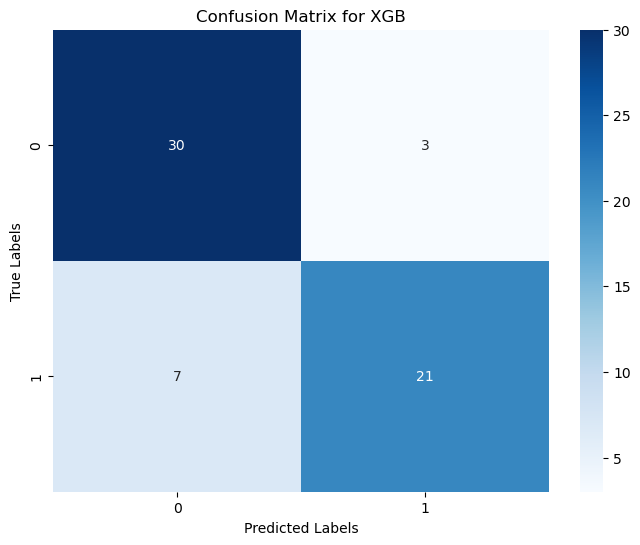

,Model,Best CV Score,Validation Accuracy,Test Accuracy,Best Parameters
2,GBC,0.879396,0.786885,0.885246,"{'model__learning_rate': 0.1, 'model__max_dept..."
1,RFC,0.887381,0.819672,0.868852,"{'model__max_depth': None, 'model__min_samples..."
3,XGB,0.865094,0.836066,0.836066,"{'model__learning_rate': 0.01, 'model__max_dep..."
0,DTC,0.838505,0.786885,0.819672,"{'model__criterion': 'entropy', 'model__max_de..."


In [46]:
names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(f1_score)
val_grid_search_selected_models(param_grid, names, models, X_bl, y_bl, metric)

# Notice the Validation score is far less accurate than the test test. This could have a number of implications, it could mean our dataset is far too small and the examples in the validation set are not enough to generalize while it performs better on the test set. Due to lack of data, it might be hard to gather concrete inferences from the data.

# Feature Selection

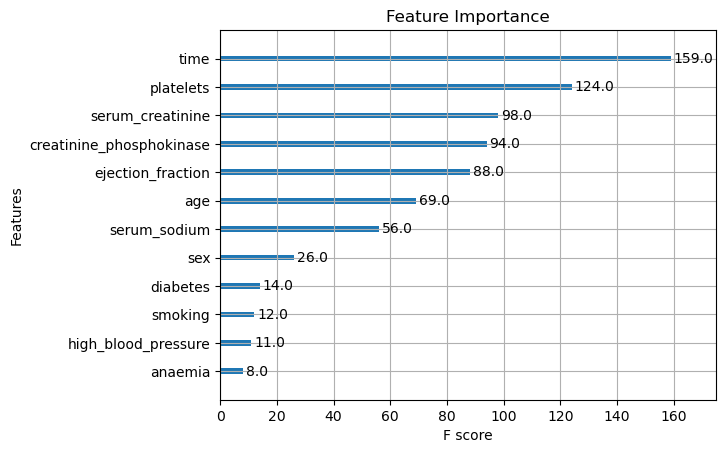

In [41]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_bl, y_bl)

importances = model.feature_importances_

xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

# PCA Analysis

In [47]:
pca_analysis(X_bl)

,Number of Components,Cumulative Explained Variance
0,1,0.135330
1,2,0.265444
2,3,0.378135
3,4,0.474966
4,5,0.561183
5,6,0.640224
6,7,0.711488
7,8,0.780306
8,9,0.846088
9,10,0.902997


# 70-90% of the data is between 7 - 10 columns, lets try to reduce dimensionality

# F-Stat

In [54]:
names = ["RFC", "XGB", "GBC", "SVC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
variance_window = range(7,11+1)
metric = f_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'F-Stat', variance_window)

Average total Score: 0.8828294165397865


,Model,Col #,Metric,Mean,STD
12,RFC,11,F-Stat,0.891698,0.022606
9,RFC,10,F-Stat,0.886488,0.022952
13,XGB,11,F-Stat,0.885358,0.024430
6,RFC,9,F-Stat,0.885267,0.028037
0,RFC,7,F-Stat,0.884938,0.026028
10,XGB,10,F-Stat,0.884936,0.023581
14,GBC,11,F-Stat,0.884533,0.027069
2,GBC,7,F-Stat,0.883807,0.028823
5,GBC,8,F-Stat,0.882653,0.027926
3,RFC,8,F-Stat,0.881082,0.026723


In [55]:
names = ["RFC", "XGB", "GBC", "SVC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
variance_window = range(7,11+1)
metric = mutual_info_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'Mutal-Info', variance_window)

Average total Score: 0.8881256457014188


,Model,Col #,Metric,Mean,STD
12,RFC,11,Mutal-Info,0.898982,0.022622
0,RFC,7,Mutal-Info,0.896238,0.025768
9,RFC,10,Mutal-Info,0.892682,0.022147
10,XGB,10,Mutal-Info,0.891967,0.024763
4,XGB,8,Mutal-Info,0.891806,0.029566
7,XGB,9,Mutal-Info,0.890913,0.021085
13,XGB,11,Mutal-Info,0.889128,0.022082
3,RFC,8,Mutal-Info,0.886611,0.030797
6,RFC,9,Mutal-Info,0.886550,0.026237
5,GBC,8,Mutal-Info,0.886279,0.031799


# Mutal Info has the higher score so lets test with a number of different scores on our best models

In [ ]:
names = ["RFC", "XGB", "GBC", "SVC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
variance_window = range(7,11+1)
metric = mutual_info_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'Mutal-Info', variance_window)